# 4D Fast Accurate Fourier Transform - (64, 64, 64, 64)
## Complex to Complex

In [14]:
import numpy as np
import ctypes
from ctypes import *

import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math

import time

In [15]:
%matplotlib inline    

## Loading FFT routines

In [16]:
DIR_BASE = "/home/robert/Documents/FAFT/FAFT_versions/FAFT_64_Z2Z/"

# FAFT 64-points
_faft64_4D = ctypes.cdll.LoadLibrary( DIR_BASE+'FAFT64_4D_Z2Z.so' )
_faft64_4D.FAFT64_4D_Z2Z.restype = int
_faft64_4D.FAFT64_4D_Z2Z.argtypes = [ctypes.c_void_p, ctypes.c_double, ctypes.c_double, 
                                       ctypes.c_int, ctypes.c_int, ctypes.c_double ]

faft64  = _faft64_4D.FAFT64_4D_Z2Z
ifaft64 = _faft64_4D.IFAFT64_4D_Z2Z


## Initializing Grid

In [17]:
def Gaussian(x,mu,sigma):
    return np.exp( - (x-mu)**2/sigma**2/2. , dtype=np.float64 )/(sigma*np.sqrt( 2*np.pi  ))

def fftGaussian(p,mu,sigma):
    return np.exp(-1j*mu*p , dtype=np.float64 )*np.exp( - p**2*sigma**2/2. , dtype=np.float64 )

 The 4D space is defined as: 
 $(x, p_x, y, p_y)$ and is known as the PHASE SPACE

 The Fourier transformed 4D space is defined as: 
 $(\lambda_x, \theta_x, \lambda_y, \theta_y)$ and is known as the AMBIGUITY SPACE

In [18]:
gridDIM_p_y = 64     #axis 0
gridDIM_y   = 64     #axis 1    
gridDIM_p_x = 64     #axis 2
gridDIM_x   = 64     #axis 3

size = gridDIM_y*gridDIM_p_y*gridDIM_x*gridDIM_p_x

axes0 = 0
axes1 = 1
axes2 = 2
axes3 = 3

#m = size

segment_axes0 = 0
segment_axes1 = 0
segment_axes2 = 0
segment_axes3 = 0

normFactor = 1

In [19]:
# Phase space window 
p_y_amplitude = 7.    #axis 0
y_amplitude   = 7.    #axis 1
p_x_amplitude = 7.    #axis 2
x_amplitude   = 7     #axis 3

# Ambiguity space window 
theta_y_amplitude  = 9.   #axis 0             
lambda_y_amplitude = 9.   #axis 1
theta_x_amplitude  = 9.   #axis 2
lambda_x_amplitude = 9.   #axis 3

# Phase space step size 
dp_y  = 2*p_y_amplitude/float(gridDIM_p_y)           #axis 0
dy    = 2*y_amplitude  /float(gridDIM_y)             #axis 1
dp_x  = 2*p_x_amplitude/float(gridDIM_p_x)           #axis 2
dx    = 2*x_amplitude  /float(gridDIM_x)             #axis 3  

# Ambiguity space step size
dtheta_y  = 2*theta_y_amplitude /float(gridDIM_y)     #axis 0
dlambda_y = 2*lambda_y_amplitude/float(gridDIM_p_y)   #axis 1
dtheta_x  = 2*theta_x_amplitude /float(gridDIM_x)     #axis 2
dlambda_x = 2*lambda_x_amplitude/float(gridDIM_p_x)   #axis 3

# delta parameters
delta_p_y =   dp_y*dtheta_y/(2*np.pi)     #axis 0
delta_y  =      dy*dlambda_y/(2*np.pi)    #axis 1
delta_p_x =   dp_x*dtheta_x/(2*np.pi)     #axis 2
delta_x  =      dx*dlambda_x/(2*np.pi)    #axis 3

# Phase space range
p_y_range = np.linspace( -p_y_amplitude, p_y_amplitude-dp_y,  gridDIM_p_y)    #axis 0
y_range   = np.linspace( -y_amplitude,   y_amplitude  -dy,    gridDIM_y  )    #axis 1
p_x_range = np.linspace( -p_x_amplitude, p_x_amplitude-dp_x,  gridDIM_p_x)    #axis 2
x_range   = np.linspace( -x_amplitude,   x_amplitude  -dx,    gridDIM_x  )    #axis 3

# Ambiguity space range
theta_y_range  = np.linspace( -theta_y_amplitude,  theta_y_amplitude -dtheta_y,    gridDIM_y   ) #axis0 
lambda_y_range = np.linspace( -lambda_y_amplitude, lambda_y_amplitude-dlambda_y,   gridDIM_p_y ) #axis1
theta_x_range  = np.linspace( -theta_x_amplitude,  theta_x_amplitude -dtheta_x,    gridDIM_x   ) #axis 2
lambda_x_range = np.linspace( -lambda_x_amplitude, lambda_x_amplitude-dlambda_x,   gridDIM_p_x ) #axis 3

# Grid 
y   =   y_range[ np.newaxis, :, np.newaxis, np.newaxis ]   #axis 1
p_y = p_y_range[ :, np.newaxis, np.newaxis, np.newaxis ]   #axis 0
p_x = p_x_range[ np.newaxis, np.newaxis, :, np.newaxis ]   #axis 2
x   =   x_range[ np.newaxis, np.newaxis, np.newaxis, : ]   #axis 3


In [20]:
def norm_GPU(W):
    return gpuarray.sum(W).real.get()*dx*dy*dp_x*dp_y

## Initializing the state

In [21]:
# Gaussian parameters in the Phase space -------------------------

y_mu = 1.;     y_sigma = 1.        #axis 1
p_y_mu = 1.;   p_y_sigma = 1.      #axis 0
p_x_mu = 1.;   p_x_sigma = 1.      #axis 2
x_mu = 1.;     x_sigma = 1.        #axis 3


#-----------------------------------------------------------------

f = Gaussian(x,x_mu,x_sigma)*Gaussian(y,y_mu,y_sigma)*Gaussian(p_x,p_x_mu, p_x_sigma)*Gaussian(p_y,p_y_mu,p_y_sigma)

#f = f + 1j*np.zeros_like(f)
f = f + 0j

print ' Amplitude x = ',  x_amplitude
print ' Amplitude p_x = ',p_x_amplitude
print '        '

print 'mu_x = ', x_mu
print 'mu_y = ', y_mu
print 'p_x_mu = ', p_x_mu
print 'p_y_mu = ', p_y_mu

print '   '

print 'n     = ', x.size
print 'dx    = ', dx
print 'dp_x    = ', dp_x
print '           standard fft dp = ',2 * np.pi /( 2*x_amplitude ) , '     '
print '    '
print 'delta_x = ', delta_x


print '    '

print 'The Gaussian extends to the numerical error in single precision:'  
print '    min = ', np.min(f.real)

print '  '
print 'Normalization = ', np.sum( f ).real*dx*dy*dp_x*dp_y
print ' '
print 'Axis = [ x , px , y , py ]   ->   [ lambda_x , theta_x , lambda_y , theta_y ]  '

 Amplitude x =  7
 Amplitude p_x =  7.0
        
mu_x =  1.0
mu_y =  1.0
p_x_mu =  1.0
p_y_mu =  1.0
   
n     =  64
dx    =  0.21875
dp_x    =  0.21875
           standard fft dp =  0.448798950513      
    
delta_x =  0.00979175919413
    
The Gaussian extends to the numerical error in single precision:
    min =  6.5154824553e-58
  
Normalization =  0.999999992829
 
Axis = [ x , px , y , py ]   ->   [ lambda_x , theta_x , lambda_y , theta_y ]  


max-min =  0.00923695313207    1.49451039318e-30


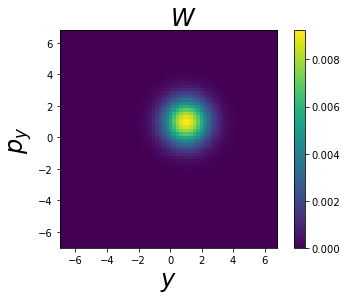

In [22]:
# Phase space y
plt.imshow( f[gridDIM_x/2, gridDIM_p_x/2, :, : ].real, 
           extent=[-y_amplitude , y_amplitude-dy, -p_y_amplitude , p_y_amplitude-dp_y] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 7.1, '$W$' , **axis_font)
plt.xlabel('$y$',**axis_font)
plt.ylabel('$p_y$',**axis_font)

plt.colorbar()

print 'max-min = ', f[gridDIM_x/2, gridDIM_p_x/2, :, : ].real.max(), '  ', f[gridDIM_x/2, gridDIM_p_x/2, :, : ].real.min()

max-min =  0.00923695313207    1.49451039318e-30


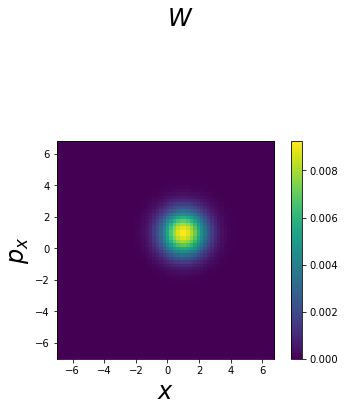

In [23]:
# Phase space x 
plt.imshow( f[:, :, gridDIM_y/2, gridDIM_p_y/2].real, 
           extent=[-x_amplitude , x_amplitude-dx, -p_x_amplitude , p_x_amplitude-dp_x] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 14.1, '$W$' , **axis_font)
plt.xlabel('$x$',**axis_font)
plt.ylabel('$p_x$',**axis_font)

plt.colorbar()

print 'max-min = ', f[:, :, gridDIM_y/2, gridDIM_p_y/2].real.max(), '  ', f[:, :, gridDIM_y/2, gridDIM_p_y/2].real.min()

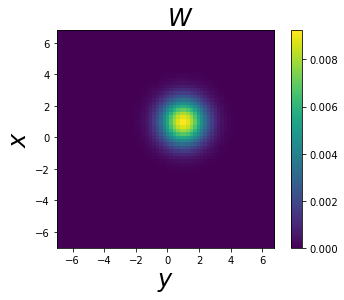

In [24]:
# Configuration space  
plt.imshow( f[ :, gridDIM_p_x/2 , : , gridDIM_p_y/2].real, 
           extent=[-y_amplitude , y_amplitude-dy, -x_amplitude , x_amplitude-dx] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 7.1, '$W$' , **axis_font)
plt.xlabel('$y$',**axis_font)
plt.ylabel('$x$',**axis_font)
plt.axes().set_aspect(1)
plt.colorbar()

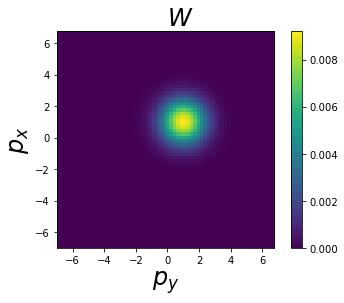

In [25]:
# Momentum space
plt.imshow( f[gridDIM_x/2 , :, gridDIM_y/2, :  ].real, 
           extent=[-p_y_amplitude , p_y_amplitude-dp_y, -p_x_amplitude , p_x_amplitude-dp_x] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 7.1, '$W$' , **axis_font)
plt.xlabel('$p_y$',**axis_font)
plt.ylabel('$p_x$',**axis_font)
plt.axes().set_aspect(1)
plt.colorbar()

## $W$ TRANSFORM

In [31]:
# Allocate GPU memory and copy data to GPU

print '         GPU memory Total              ', pycuda.driver.mem_get_info()[1]/float(2**30) , 'GB'
print '         GPU memory Free  (Before)     ', pycuda.driver.mem_get_info()[0]/float(2**30) , 'GB'

#F_gpu = gpuarray.zeros( ( gridDIM_p_y, gridDIM_y, gridDIM_p_x, gridDIM_x ), dtype=np.complex128 )
F_gpu = gpuarray.zeros( ( gridDIM_x, gridDIM_p_x, gridDIM_y, gridDIM_p_y ), dtype=np.complex128 )

F_gpu[:,:,:,:] = f[:,:,:,:]

print '         GPU memory Free  (After)      ', pycuda.driver.mem_get_info()[0]/float(2**30) , 'GB'

#F_gpu[:,:] = np.ascontiguousarray( f, dtype = np.complex64 )[:,:]

         GPU memory Total               1.94738769531 GB
         GPU memory Free  (Before)      1.4755859375 GB
         GPU memory Free  (After)       1.4755859375 GB


In [32]:
print F_gpu.shape
print f.shape
#print f
#print f[np.newaxis,:,:].shape

(64, 64, 64, 64)
(64, 64, 64, 64)


In [33]:
(5.1767578125 - 4.62921142578)*10

5.475463867199997

### Forward Transform

In [34]:
# Executing FFT

t_init = time.time() 

faft64( int(F_gpu.gpudata), dp_y, delta_p_y, segment_axes0, axes0, normFactor )
faft64( int(F_gpu.gpudata), dy,   delta_y,   segment_axes1, axes1, normFactor )
faft64( int(F_gpu.gpudata), dp_x, delta_p_x, segment_axes2, axes2, normFactor )
faft64( int(F_gpu.gpudata), dx,   delta_x,   segment_axes3, axes3, normFactor )

t_end = time.time() 

print 'computation time = ', t_end - t_init

computation time =  12.2131929398


In [35]:
print ' deltas =' , delta_x, delta_p_x, delta_y, delta_p_y

 deltas = 0.00979175919413 0.00979175919413 0.00979175919413 0.00979175919413


In [36]:
# Arbitrary Renormalization 
F_gpu /= size

max-min =  14.783137257    -2.83495206073


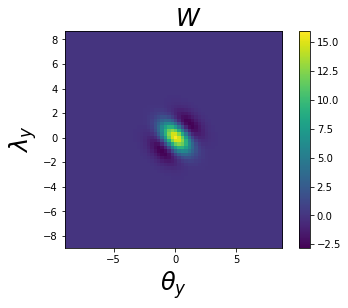

In [37]:
# Ambiguity space y

plt.imshow( F_gpu.get()[gridDIM_x/2, gridDIM_p_x/2, :, : ].real, 
           extent=[lambda_y_amplitude-dlambda_y, -lambda_y_amplitude, theta_y_amplitude-dtheta_y, -theta_y_amplitude] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 9.1, '$W$' , **axis_font)
plt.xlabel('$\\theta_y$',**axis_font)
plt.ylabel('$\\lambda_y$',**axis_font)

plt.colorbar()

print 'max-min = ', F_gpu.get()[gridDIM_x/2, gridDIM_p_x/2, :, : ].real.max(), '  ', F_gpu.get()[gridDIM_x/2, gridDIM_p_x/2, :, :].real.min()

max-min =  15.9999998853    -2.83495206073


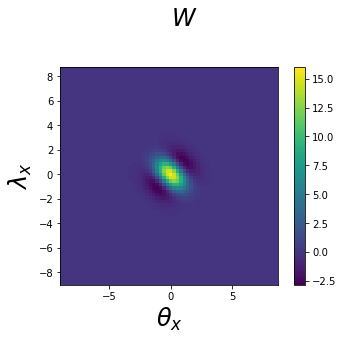

In [20]:
# Ambiguity space x

plt.imshow( F_gpu.get()[ :, :, gridDIM_y/2, gridDIM_p_y/2].real, 
           extent=[-lambda_x_amplitude , lambda_x_amplitude-dlambda_x, -theta_x_amplitude, theta_x_amplitude-dtheta_x] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 12.1, '$W$' , **axis_font)
plt.xlabel('$\\theta_x$',**axis_font)
plt.ylabel('$\\lambda_x$',**axis_font)

plt.colorbar()

print 'max-min = ', F_gpu.get()[ :, :, gridDIM_y/2, gridDIM_p_y/2 ].real.max(), '  ', F_gpu.get()[ :, :, gridDIM_y/2, gridDIM_p_y/2 ].real.min()

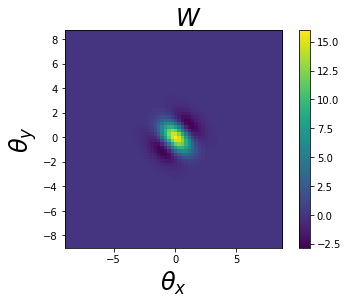

In [21]:
# Conjugate configuration space

plt.imshow( F_gpu.get()[ gridDIM_p_y/2 , :: , gridDIM_p_x/2 , :: ].real, 
           extent=[-theta_x_amplitude , theta_x_amplitude-dtheta_x, -theta_y_amplitude , theta_y_amplitude-dtheta_y] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 9.1, '$W$' , **axis_font)
plt.xlabel('$\\theta_x$',**axis_font)
plt.ylabel('$\\theta_y$',**axis_font)
plt.axes().set_aspect(1)
plt.colorbar()

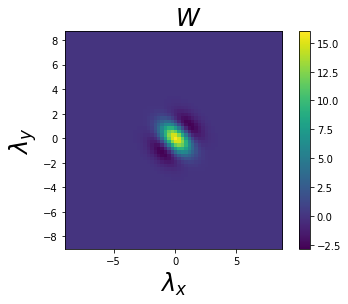

In [22]:
# Conjugate momentum space

plt.imshow( F_gpu.get()[ :, gridDIM_y/2 , :, gridDIM_x/2  ].real, 
           extent=[-lambda_x_amplitude , lambda_x_amplitude-dlambda_x, -lambda_y_amplitude , lambda_y_amplitude-dlambda_y] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 9.2, '$W$' , **axis_font)
plt.xlabel('$\\lambda_x$',**axis_font)
plt.ylabel('$\\lambda_y$',**axis_font)
plt.axes().set_aspect(1)
plt.colorbar()

### Inverse Transform

In [23]:
# Executing iFFT
# Calling the kernels with -delta_y, -delta_x, -delta_z, -delta_u

t_init = time.time() 

ifaft64( int(F_gpu.gpudata), dp_y, delta_p_y, segment_axes0, axes0, normFactor )
ifaft64( int(F_gpu.gpudata), dy,   delta_y,   segment_axes1, axes1, normFactor )
ifaft64( int(F_gpu.gpudata), dp_x, delta_p_x, segment_axes2, axes2, normFactor )
ifaft64( int(F_gpu.gpudata), dx,   delta_x,   segment_axes3, axes3, normFactor )

t_end = time.time()

print 'computation time = ', t_end - t_init

computation time =  18.5252840519


In [24]:
norm = norm_GPU(F_gpu)
F_gpu /= norm

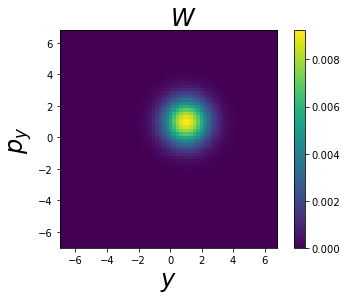

In [25]:
# Phase space y
#
# The AMPLITUDE IN Py IS TOO BIG. THERE MUST BE AN ERROR 
#
plt.imshow( F_gpu.get()[::,::,gridDIM_p_x/2, gridDIM_x/2 ].real, 
           extent=[-y_amplitude , y_amplitude-dx, -p_y_amplitude , p_y_amplitude-dp_y] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 7.1, '$W$' , **axis_font)
plt.xlabel('$y$',**axis_font)
plt.ylabel('$p_y$',**axis_font)

plt.colorbar()



max-min =  0.00923695320506    -4.58532727689e-13


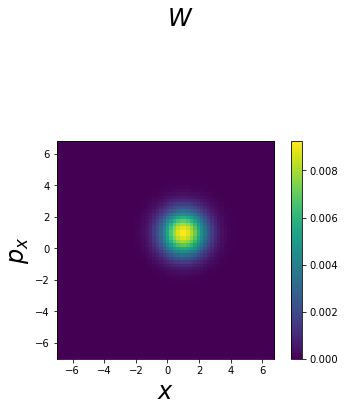

In [26]:
# Phase space x

plt.imshow( F_gpu.get()[ gridDIM_p_y/2, gridDIM_y/2 , :, :].real, 
           extent=[-x_amplitude , x_amplitude-dx, -p_x_amplitude , p_x_amplitude-dp_x] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 14.1, '$W$' , **axis_font)
plt.xlabel('$x$',**axis_font)
plt.ylabel('$p_x$',**axis_font)

plt.colorbar()

print 'max-min = ', F_gpu.get()[ gridDIM_p_y/2, gridDIM_y/2 , :, :].real.max(), '  ', F_gpu.get()[ gridDIM_p_y/2, gridDIM_y/2 , :, :].real.min()

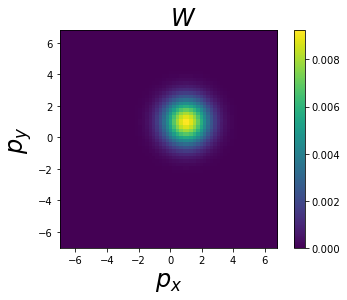

In [27]:
# Momentum space
plt.imshow( F_gpu.get()[ :, gridDIM_y/2 , :, gridDIM_x/2  ].real, 
           extent=[-p_x_amplitude , p_x_amplitude-dx, -p_y_amplitude , p_y_amplitude-dy] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 7.1, '$W$' , **axis_font)
plt.xlabel('$p_x$',**axis_font)
plt.ylabel('$p_y$',**axis_font)
plt.axes().set_aspect(1)
plt.colorbar()

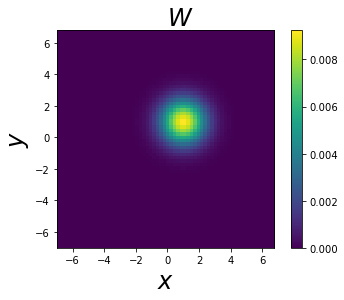

In [28]:
# Configuration space
plt.imshow( F_gpu.get()[ gridDIM_p_y/2, : , gridDIM_p_x/2, :  ].real, 
           extent=[-x_amplitude , x_amplitude-dx, -y_amplitude , y_amplitude-dy] ,
           origin='lower', interpolation='none')

axis_font = {'size':'24'}
plt.text( 0., 7.1, '$W$' , **axis_font)
plt.xlabel('$x$',**axis_font)
plt.ylabel('$y$',**axis_font)
plt.axes().set_aspect(1)
plt.colorbar()

(1e-20, 1)

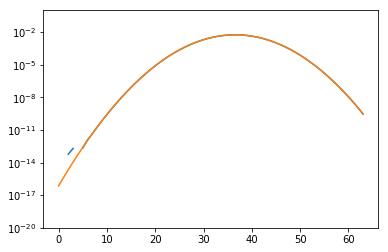

In [29]:
plt.semilogy(
F_gpu.get()[ gridDIM_p_y/2, gridDIM_y/2 , :, gridDIM_x/2  ].real )

plt.semilogy(
f[ gridDIM_p_y/2, gridDIM_y/2 , :, gridDIM_x/2  ].real )

plt.ylim(1e-20,1)